# Import Dependencies

In [20]:
!pip install transformers==3.0.0

In [21]:
#Get rid of annoying tensorflow warnings
import logging
logging.getLogger().setLevel(logging.CRITICAL)
import warnings
warnings.filterwarnings('ignore')

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score
from transformers import AdamW, RobertaTokenizer, RobertaForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax
import os
import sys 
from torch import nn, optim
from torch.nn import functional as F
import json

# Import Dataset, Define Model, Preprocessing

In [22]:
def Extract_Headlines():
    # Open Sarcasm JSON File
    f = open ('/content/Sarcasm_Headlines_Dataset_v2.json', "r") 
    data = json.loads(f.read()) 
    f.close()
    labels = [] # list of correct labels
    headlines = [] # list of headlines

    max_length = 0 
    # get data from file
    for item in data: 
        label = int(item['is_sarcastic'])
        headline = item['headline']
        labels.append(label)
        headlines.append(headline)
        if len(headline.split()) > max_length:
            max_length = len(headline.split())
    # convert to numpy array before use
    return labels, headlines, max_length

In [23]:
def flat_accuracy(preds, labels):
  pred_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()
  return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [24]:
# number of classes  
num_classes = 2 
batch_size = 4

model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=num_classes, output_hidden_states=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer =  RobertaTokenizer.from_pretrained('roberta-base', do_lower_case=True)

gold_labels, sentences, MAX_LEN  = Extract_Headlines()

MAX_LEN = 64
    
# tokenize
encoded_inputs = tokenizer(sentences, padding='max_length', truncation=True, max_length=MAX_LEN) 

input_ids = encoded_inputs["input_ids"]
attention_masks = encoded_inputs["attention_mask"]

In [25]:
# tvt splits
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, gold_labels, random_state=2020, test_size=0.4)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids, random_state=2020, test_size=0.4)

temp_val = validation_inputs
validation_inputs, test_inputs, validation_labels, test_labels = train_test_split(temp_val, validation_labels, random_state=2020, test_size=0.5)
validation_masks,test_masks, _, _ = train_test_split(validation_masks, temp_val, random_state=2020, test_size=0.5)

# Package data into dataloaders
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)

validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

test_inputs = torch.tensor(test_inputs)
test_labels = torch.tensor(test_labels)
test_masks = torch.tensor(test_masks)

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size*4)

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size*4)

# send model to GPU
model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm

In [26]:
# Set paramters and optimizer
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
  {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
  'weight_decay_rate': 0.01},
{'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
  'weight_decay_rate': 0.0}                             
]
optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)


# Training and Validation


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

 train losss: 0.3050501216000678


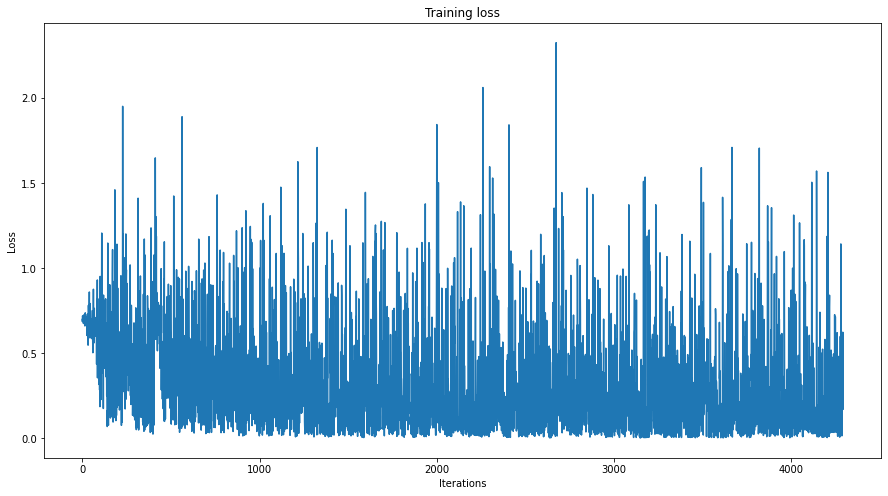


Epoch:  33%|███▎      | 1/3 [14:16<28:32, 856.44s/it]

validation accuracy: 0.9136405959031657
 train losss: 0.17355652347308706


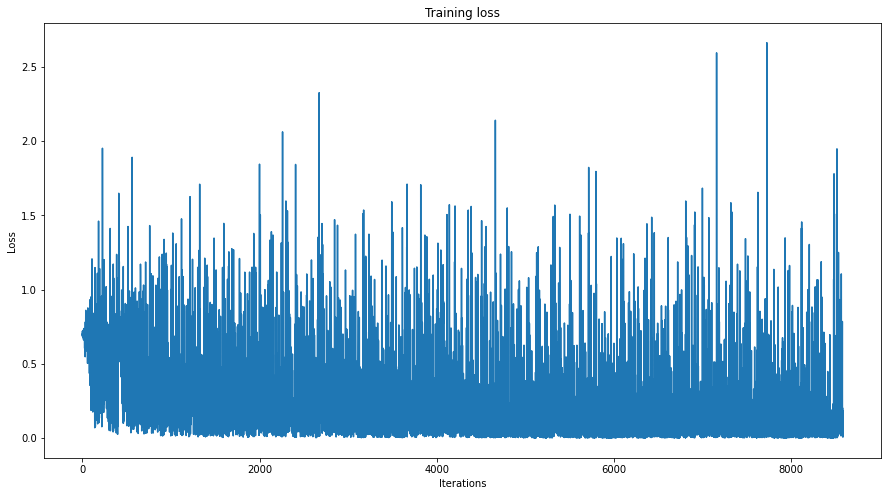


Epoch:  67%|██████▋   | 2/3 [28:28<14:15, 855.13s/it]

validation accuracy: 0.9192271880819366
 train losss: 0.11658931812172768


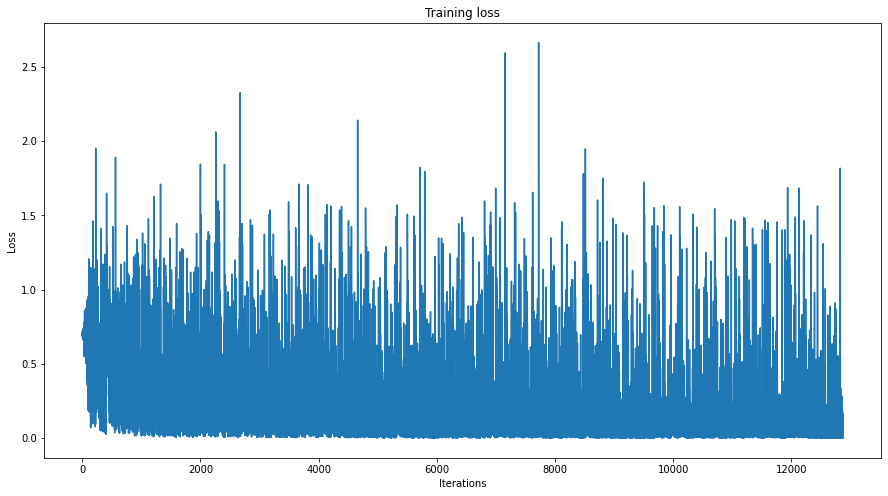


Epoch: 100%|██████████| 3/3 [42:34<00:00, 851.57s/it]

validation accuracy: 0.9279562383612663


In [27]:
#keep track of loss for plotting
train_loss_set = []
epochs = 3

#training loop
for epoch in trange(epochs, desc="Epoch"):
    model.train()
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0,0

    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        optimizer.zero_grad()

        b_input_ids = b_input_ids.clone().detach().to(device).long()
        outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        loss, logits, states = outputs

        train_loss_set.append(loss.item())
        loss.backward()
        optimizer.step()
        #scheduler.step()

        #gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1
    print(" train losss: {}".format(tr_loss/nb_tr_steps))
    #plot training loss
    plt.figure(figsize=(15,8))
    plt.title("Training loss")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.plot(train_loss_set)
    plt.show() 


    # Model Validation
    model.eval()

    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        b_input_ids = b_input_ids.clone().detach().to(device).long()
        with torch.no_grad():
            logits = model(b_input_ids, attention_mask=b_input_mask)
        logits = logits[0].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1
    print("validation accuracy: {}".format(eval_accuracy/nb_eval_steps))

    #add code here to save model to file if it has better performance than before
   

# Testing

In [28]:
#Test phase
model.eval()

logits_list = []
labels_list = []

for batch in test_dataloader:
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask, b_labels = batch
  with torch.no_grad():
    logits = model(b_input_ids, attention_mask=b_input_mask)
  logits_list.append(logits[0])
  labels_list.append(b_labels)
# Flattened list of logits and the corresponding labels
logits_list = torch.cat(logits_list)
labels_list = torch.cat(labels_list)
softmaxes = F.softmax(logits_list, dim=1)
_, predictions_list = torch.max(softmaxes, dim=1)
precision, recall, f1, _ = precision_recall_fscore_support(labels_list.detach().cpu().numpy(),predictions_list.detach().cpu().numpy(), average='weighted')
acc = accuracy_score(labels_list.detach().cpu().numpy(), predictions_list.detach().cpu().numpy())
print('F1 Score: {}, Precision: {}, Recall: {}, Accuracy: {}'.format(f1, precision,recall,acc ))


F1 Score: 0.9328688771371771, Precision: 0.933246256291609, Recall: 0.9329140461215933, Accuracy: 0.9329140461215933


## Test User Input

In [ ]:
input_sentence = "Man dies of excitement after watching paint dry."
def Predict_Sample(device, model, sentence, max_len=100):
    tokenizer =  RobertaTokenizer.from_pretrained('roberta-base', do_lower_case=True)
    
    inputs = tokenizer(sentence, padding='max_length', truncation=True, max_length=max_len, return_tensors="pt")
    input_id = inputs["input_ids"]
    input_mask = inputs["attention_mask"]
    model.eval()
    logits = model(input_id.to(device).long(), attention_mask=input_mask.to(device))
    prediction = logits[0]
    softmax_logits = F.softmax(prediction, dim=1)
    score, predicted = softmax_logits.max(1)
    print('The predicted score for your input sentence "{}"  is Class {} with confidence: {}'.format(sentence,predicted.item(), score.item()))
Predict_Sample(device, model, input_sentence)

# Function Used to Build Notebook

In [17]:
def Run_Model(device, batch_size, num_epochs, learningrate=2e-5):


    #number of classes  
    num_classes = 2 

    model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=num_classes, output_hidden_states=True)
    tokenizer =  RobertaTokenizer.from_pretrained('roberta-base', do_lower_case=True)

    gold_labels, sentences, MAX_LEN  = Extract_Headlines()

    # print(MAX_LEN)
    # MAX_LEN += 20

    MAX_LEN = 64
    
    #tokenize
    encoded_inputs = tokenizer(sentences, padding='max_length', truncation=True, max_length=MAX_LEN) 

    input_ids = encoded_inputs["input_ids"]
    attention_masks = encoded_inputs["attention_mask"]


    #Split data into train/test/validation
    train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, gold_labels, random_state=2020, test_size=0.4)
    train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids, random_state=2020, test_size=0.4)

    temp_val = validation_inputs
    validation_inputs, test_inputs, validation_labels, test_labels = train_test_split(temp_val, validation_labels, random_state=2020, test_size=0.5)
    validation_masks,test_masks, _, _ = train_test_split(validation_masks, temp_val, random_state=2020, test_size=0.5)

    #Package data into dataloaders
    train_inputs = torch.tensor(train_inputs)
    train_labels = torch.tensor(train_labels)
    train_masks = torch.tensor(train_masks)

    validation_inputs = torch.tensor(validation_inputs)
    validation_labels = torch.tensor(validation_labels)
    validation_masks = torch.tensor(validation_masks)

    test_inputs = torch.tensor(test_inputs)
    test_labels = torch.tensor(test_labels)
    test_masks = torch.tensor(test_masks)

    train_data = TensorDataset(train_inputs, train_masks, train_labels)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

    validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
    validation_sampler = SequentialSampler(validation_data)
    validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size*4)

    test_data = TensorDataset(test_inputs, test_masks, test_labels)
    test_sampler = SequentialSampler(test_data)
    test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size*4)

    #send model to GPU
    model.to(device)

    #Set paramters and optimizer
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
     {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
      'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
      'weight_decay_rate': 0.0}                             
    ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=learningrate)
    
    #Scheduler is optional
    #scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=2e-5, steps_per_epoch=len(train_dataloader), epochs=num_epochs)

    #keep track of loss for plotting
    train_loss_set = []
    epochs = num_epochs

    #training loop
    for epoch in trange(epochs, desc="Epoch"):
        model.train()
        tr_loss = 0
        nb_tr_examples, nb_tr_steps = 0,0

        for step, batch in enumerate(train_dataloader):
            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_input_mask, b_labels = batch
            optimizer.zero_grad()

            b_input_ids = b_input_ids.clone().detach().to(device).long()
            outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
            loss, logits, states = outputs

            train_loss_set.append(loss.item())
            loss.backward()
            optimizer.step()
            #scheduler.step()

            #gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            tr_loss += loss.item()
            nb_tr_examples += b_input_ids.size(0)
            nb_tr_steps += 1
        print(" train losss: {}".format(tr_loss/nb_tr_steps))
        #plot training loss
        plt.figure(figsize=(15,8))
        plt.title("Training loss")
        plt.xlabel("Iterations")
        plt.ylabel("Loss")
        plt.plot(train_loss_set)
        plt.show() 


        # Model Validation
        model.eval()

        eval_loss, eval_accuracy = 0, 0
        nb_eval_steps, nb_eval_examples = 0, 0
        for batch in validation_dataloader:
            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_input_mask, b_labels = batch
            b_input_ids = b_input_ids.clone().detach().to(device).long()
            with torch.no_grad():
                logits = model(b_input_ids, attention_mask=b_input_mask)
            logits = logits[0].detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()
            tmp_eval_accuracy = flat_accuracy(logits, label_ids)
            eval_accuracy += tmp_eval_accuracy
            nb_eval_steps += 1
        print("validation accuracy: {}".format(eval_accuracy/nb_eval_steps))

        #add code here to save model to file if it has better performance than before
    #Test phase
    model.eval()

    logits_list = []
    labels_list = []

    for batch in test_dataloader:
      batch = tuple(t.to(device) for t in batch)
      b_input_ids, b_input_mask, b_labels = batch
      with torch.no_grad():
        logits = model(b_input_ids, attention_mask=b_input_mask)
      logits_list.append(logits[0])
      labels_list.append(b_labels)
    # Flattened list of logits and the corresponding labels
    logits_list = torch.cat(logits_list)
    labels_list = torch.cat(labels_list)
    softmaxes = F.softmax(logits_list, dim=1)
    _, predictions_list = torch.max(softmaxes, dim=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels_list.detach().cpu().numpy(),predictions_list.detach().cpu().numpy(), average='weighted')
    acc = accuracy_score(labels_list.detach().cpu().numpy(), predictions_list.detach().cpu().numpy())
    print('F1 Score: {}, Precision: {}, Recall: {}, Accuracy: {}'.format(f1, precision,recall,acc ))

    return model

In [18]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

 train losss: 0.3119549946404448


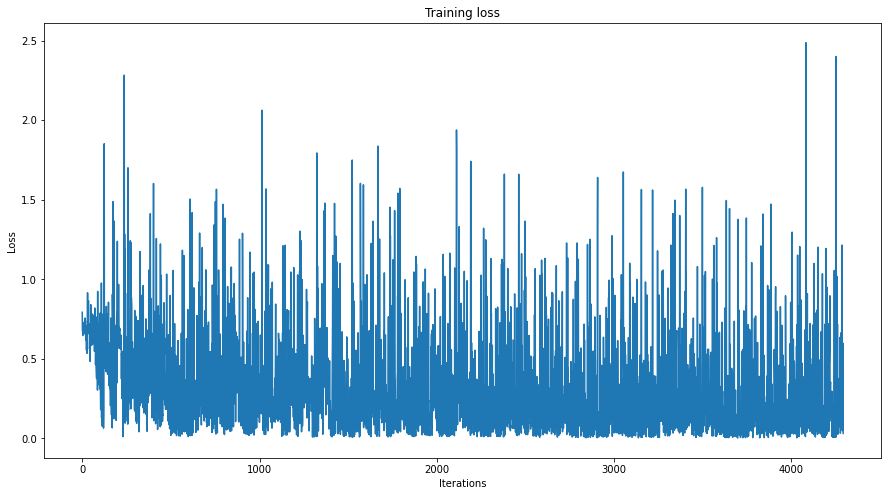


Epoch:  50%|█████     | 1/2 [14:16<14:16, 856.02s/it]

validation accuracy: 0.9214385474860335
 train losss: 0.1743423292283624


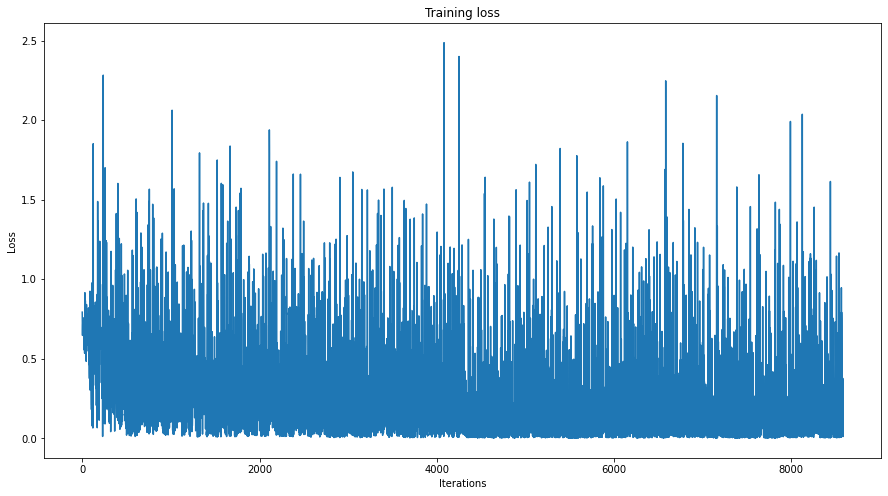


Epoch: 100%|██████████| 2/2 [28:28<00:00, 854.05s/it]

validation accuracy: 0.9206820297951583


F1 Score: 0.9259421526205565, Precision: 0.9264367669527238, Recall: 0.9259259259259259, Accuracy: 0.9259259259259259


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm

In [19]:
# Run_Model(device, batch_size=4, num_epochs=2, learningrate=2e-5)